In [1]:
# Supress pytorch pickle load warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

# Library imports
import gdiffusion as gd
import util
import util.chem as chem
import util.visualization as vis
import util.stats as gdstats


import gdiffusion.bayesopt as bayesopt
from gdiffusion.classifier.extinct_predictor import EsmClassificationHead

device = util.util.get_device()
print(f"device: {device}")

# peptide diffusion
DIFFUSION_PATH = "saved_models/peptide_model_v1-20.pt"
PEPTIDE_VAE_PATH = "saved_models/peptide_vae/peptide-vae.ckpt"
PEPTIDE_VAE_VOCAB_PATH = "saved_models/peptide_vae/vocab.json"
EXTINCT_PREDICTOR_PATH = "saved_models/extinct_model8417"

/home/alden/miniconda3/envs/pytorch-cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda


In [2]:
classifier = torch.load(EXTINCT_PREDICTOR_PATH)
classifier.eval().to(device)

diffusion = gd.create_peptide_diffusion_model(DIFFUSION_PATH, device=device)
peptide_vae = gd.load_vae_peptides(path_to_vae_statedict=PEPTIDE_VAE_PATH, vocab_path=PEPTIDE_VAE_VOCAB_PATH)


Model created successfully
- Total parameters: 225,056,257
- Trainable parameters: 225,056,257
- Model size: 858.5 MB
- Device: cuda:0
- Model Name: LatentDiffusionModel

Model created successfully
- Total parameters: 225,056,257
- Trainable parameters: 225,056,257
- Model size: 858.5 MB
- Device: cuda:0
- Model Name: LatentDiffusionModel
loading model from saved_models/peptide_vae/peptide-vae.ckpt
Enc params: 2,675,904
Dec params: 360,349


In [3]:
decode = lambda z: gd.latent_to_peptides(z, vae=peptide_vae)
encode = lambda peptide_str: gd.peptides_to_latent(peptide_str, vae=peptide_vae)

def sample_random(batch_size):
    return torch.randn(size=(batch_size, 256), device=device)

def classify(z):
    return torch.softmax(classifier(z), dim=1)

def sample(batch_size, cond_fn=None):
    return diffusion.sample(batch_size=batch_size, cond_fn=cond_fn).reshape(batch_size, 256)

def eval_probs(z):
    probs = classify(z)
    print(f"Diffusion Probs: {probs}")
    argmax = torch.argmax(probs, dim=1)
    print(f"Percent Extinct: {argmax.sum() / len(argmax)}")

In [ ]:
z = diffusion.sample(batch_size=128).reshape(-1, 256)
eval_probs(z)

DDPM Sampling loop time step: 100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]


Diffusion Probs: tensor([[9.3257e-01, 6.7425e-02],
        [8.9374e-01, 1.0626e-01],
        [5.5644e-01, 4.4356e-01],
        [6.1340e-01, 3.8660e-01],
        [8.5649e-01, 1.4351e-01],
        [7.7793e-01, 2.2207e-01],
        [4.6874e-01, 5.3126e-01],
        [9.9883e-01, 1.1718e-03],
        [7.2104e-01, 2.7896e-01],
        [8.4184e-01, 1.5816e-01],
        [5.0765e-01, 4.9235e-01],
        [6.8288e-01, 3.1712e-01],
        [9.9367e-01, 6.3298e-03],
        [9.9757e-01, 2.4260e-03],
        [4.6488e-01, 5.3512e-01],
        [9.7982e-01, 2.0185e-02],
        [9.2908e-01, 7.0917e-02],
        [4.1397e-01, 5.8603e-01],
        [8.1890e-01, 1.8110e-01],
        [9.8612e-01, 1.3877e-02],
        [9.8848e-01, 1.1518e-02],
        [8.8214e-01, 1.1786e-01],
        [9.5990e-01, 4.0098e-02],
        [7.6038e-01, 2.3962e-01],
        [9.7562e-01, 2.4381e-02],
        [5.0946e-01, 4.9054e-01],
        [8.4817e-01, 1.5183e-01],
        [4.6272e-01, 5.3728e-01],
        [4.0924e-01, 5.9076e-01

In [ ]:
# Random sampling always results in not extinct (class 0) peptide
z_rand = sample_random(batch_size=128)
classify(z_rand)

tensor([[1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0

In [ ]:
def log_prob_fn_extinct(z):
    batch_size, latent_dim = z.shape
    logits = classifier(z)
    log_prob_sum = F.log_softmax(input=logits, dim=1).sum(dim=0)
    log_prob_sum[0] *= -1
    log_prob = log_prob_sum.sum(dim=0)
    return log_prob

cond_fn_extinct = gd.get_cond_fn(
    log_prob_fn=log_prob_fn_extinct, 
    guidance_strength=1.0, 
    clip_grad=True, 
    clip_grad_max=1.0,
    latent_dim=256
)

z_guided = diffusion.sample(batch_size=128, cond_fn=cond_fn_extinct)
z_guided = z_guided.reshape(-1, 256)

DDPM Sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

DDPM Sampling loop time step: 100%|██████████| 1000/1000 [04:48<00:00,  3.46it/s]


['LMFVSKMTLFHLMKQPWSKHIILMSFLILTLFLIHPMPILP',
 'WLMILTGILFPTPEMITPTTIMILLRFILLLA',
 'AMGTKSQVLWLPVLALSIGELYSYLSEEGSGSCEAKGKIHGLLSTPTL',
 'GFPVSPMLSEIIFTMAIIFILMLLTTYDQLMYLLTWFMMW',
 'YIINTSSNVSRIFFYIMYSWISKALIYPPTMQGMSNMKKIKIIITATT',
 'DKVDAEFKRCGVPGLPAARRRRRAGRDTRA',
 'ETISITLSLISAFIPNQLSKMLIYLPMWLTSWMWLFNPIVAPMHLNNV',
 'INNPTVLTLIRLLSGWTLMMGATELSMPTILMTS',
 'TEETNEPSEVLHIGRNMTTWWRTLGLSEAYSSVKAMALAL',
 'LLTNMYILSMQSNWLTPLSMPPHLLPTTNLAALSRLIASSHLLMLMLI',
 'ENLPWLSHHITLNSMKTICNFKAVNEYW',
 'RLQPQVNDRDEPPFMVQLSNCNHCPAQIAAYGNLISSAEEG',
 'TLIMSTMLAMLLILAGIRQINQLNNLLT',
 'IMSQKMIMTMIAFSKLIIMKLPFYMSKIYTSMSPLLFLPTS',
 'WWISPLLTTKKTTL',
 'IPEPERRTVPPVREYAAIALM',
 'FHTTKMSDYFLISLAKKMTKLANHVTTSTTAMELFMKYMSXEVPLLIK',
 'EPMTLGLQNTPSMLLVQPVMDLLRKTMMSSLMLLALSLTLSL',
 'GLIMVSMMLSMLFVYSSGELLVSSVYYTSFPCWVFFNYGYWSYEYI',
 'ASRGDDDGVARSEGSVIYENNRLGIWRCQHPFEVAYYFA',
 'ELMMMVSFLYLSYSNVVSLSSSSFLWWLSARIVQLQPLPWNVEHSWIL',
 'NLSHLPPMTWLKQTWKPPTHTNIQKIALIALIPVTIILI',
 'LYGVGTSLKYFNEFLRQESYKEQLNVEVYDIGE',
 'LLYHML

In [ ]:
# save results

peptides_guided = decode(z=z_guided)
with open("data/guided_peptide_results_guided.txt", "w") as f:
    for peptide in peptides_guided:
        f.write(f"{peptide}\n")

peptides_unguided = decode(z=z)
with open("data/guided_peptide_results_unguided.txt", "w") as f:
    for peptide in peptides_unguided:
        f.write(f"{peptide}\n")

In [ ]:
print(decode(z_guided))

# sample from diffusion (no guidance)
eval_probs(z)

# sample from diffusion (with guidance)
eval_probs(z_guided)

['LMFVSKMTLFHLMKQPWSKHIILMSFLILTLFLIHPMPILP', 'WLMILTGILFPTPEMITPTTIMILLRFILLLA', 'AMGTKSQVLWLPVLALSIGELYSYLSEEGSGSCEAKGKIHGLLSTPTL', 'GFPVSPMLSEIIFTMAIIFILMLLTTYDQLMYLLTWFMMW', 'YIINTSSNVSRIFFYIMYSWISKALIYPPTMQGMSNMKKIKIIITATT', 'DKVDAEFKRCGVPGLPAARRRRRAGRDTRA', 'ETISITLSLISAFIPNQLSKMLIYLPMWLTSWMWLFNPIVAPMHLNNV', 'INNPTVLTLIRLLSGWTLMMGATELSMPTILMTS', 'TEETNEPSEVLHIGRNMTTWWRTLGLSEAYSSVKAMALAL', 'LLTNMYILSMQSNWLTPLSMPPHLLPTTNLAALSRLIASSHLLMLMLI', 'ENLPWLSHHITLNSMKTICNFKAVNEYW', 'RLQPQVNDRDEPPFMVQLSNCNHCPAQIAAYGNLISSAEEG', 'TLIMSTMLAMLLILAGIRQINQLNNLLT', 'IMSQKMIMTMIAFSKLIIMKLPFYMSKIYTSMSPLLFLPTS', 'WWISPLLTTKKTTL', 'IPEPERRTVPPVREYAAIALM', 'FHTTKMSDYFLISLAKKMTKLANHVTTSTTAMELFMKYMSXEVPLLIK', 'EPMTLGLQNTPSMLLVQPVMDLLRKTMMSSLMLLALSLTLSL', 'GLIMVSMMLSMLFVYSSGELLVSSVYYTSFPCWVFFNYGYWSYEYI', 'ASRGDDDGVARSEGSVIYENNRLGIWRCQHPFEVAYYFA', 'ELMMMVSFLYLSYSNVVSLSSSSFLWWLSARIVQLQPLPWNVEHSWIL', 'NLSHLPPMTWLKQTWKPPTHTNIQKIALIALIPVTIILI', 'LYGVGTSLKYFNEFLRQESYKEQLNVEVYDIGE', 'LLYHMLGQELEFIAWKRKQAMVCDLLDRP

In [ ]:
probs_z_rand_extinct = torch.softmax(input=classifier(z_rand), dim=-1)[:, 1].cpu().detach()
probs_z_extinct = torch.softmax(classifier(z), dim=-1)[:, 1].cpu().detach()
probs_z_guided_extinct = torch.softmax(classifier(z_guided), dim=-1)[:, 1].cpu().detach()

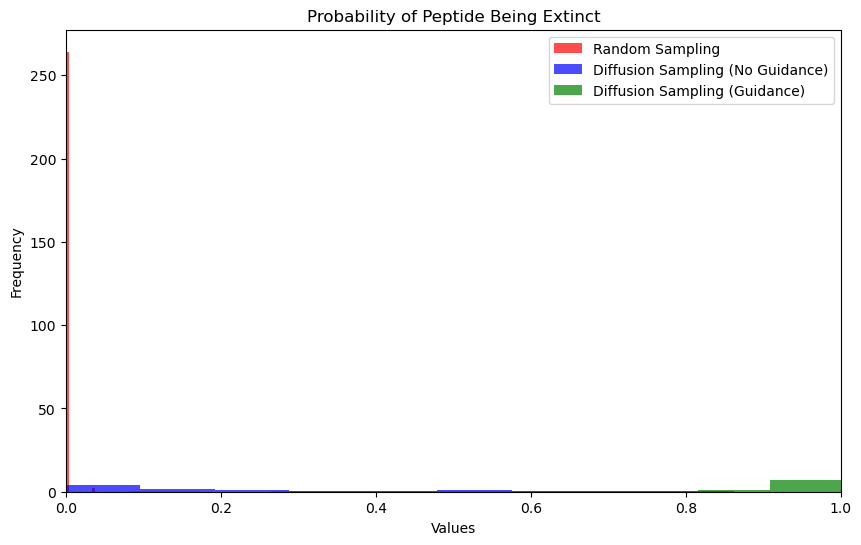

In [ ]:
array_list=[probs_z_rand_extinct, probs_z_extinct, probs_z_guided_extinct]
label_list=["Random Sampling", "Diffusion Sampling (No Guidance)", "Diffusion Sampling (Guidance)"]
plt.figure(figsize=(10, 6))

color_list = ['red', 'blue', 'green', 'yellow', 'pink', 'purple']
for array, label, color in zip(array_list, label_list, color_list):
    plt.hist(array, alpha=0.7, label=label, density=True, color=color)

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Probability of Peptide Being Extinct')
plt.legend()
plt.xlim(0, 1)
plt.show()